# Setup

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from joblib import Parallel, delayed

In [2]:
np.random.seed(42)

In [3]:
REVIEWS_PATH  = "./data/Video_Games_5.json.gz"
METADATA_PATH = "./data/meta_Video_Games.json.gz"

In [4]:
REVIEWS_FEATS = ['asin', 'reviewerID', 'overall']
METADATA_FEATS = ['asin', 'title']

In [5]:
NUM_PRODUCTS = 10000
K = 5

# Load and transform data

In [6]:
# Load review data
reviews = pd.read_json(REVIEWS_PATH, lines=True, compression='gzip', encoding = 'utf-8')
reviews = reviews[REVIEWS_FEATS]
reviews.head(5)

,asin,reviewerID,overall
0,0700026657,A1HP7NVNPFMA4N,5
1,0700026657,A1JGAP0185YJI6,4
2,0700026657,A1YJWEXHQBWK2B,3
3,0700026657,A2204E1TH211HT,2
4,0700026657,A2RF5B5H74JLPE,5


In [7]:
# TODO: try to incorporate metadata
# Load product metadata
metadata = pd.read_json(METADATA_PATH, lines=True, compression='gzip', encoding = 'utf-8')
metadata = metadata[METADATA_FEATS]
metadata.head(5)

,asin,title
0,0042000742,Reversi Sensory Challenger
1,0078764343,Medal of Honor: Warfighter - Includes Battlefi...
2,0276425316,street fighter 2 II turbo super nintendo snes ...
3,0324411812,Xbox 360 MAS STICK
4,0439335310,Phonics Alive! 3: The Speller


In [8]:
# Subset the data
sample_asins = np.random.choice(reviews['asin'].unique(), size=NUM_PRODUCTS, replace=False)
reviews = reviews[reviews['asin'].isin(sample_asins)]

In [9]:
# Preprocess data for item-based collaborative filtering
user_item_matrix = reviews.pivot_table(index='reviewerID', columns='asin', values='overall').fillna(0)
item_user_matrix = user_item_matrix.T
item_user_matrix.shape

(10000, 54653)

In [10]:
# Standardize the matrix
scaler = StandardScaler()
standardized_matrix = scaler.fit_transform(item_user_matrix)

In [11]:
# Calculate item-item similarity using cosine similarity
item_similarity = cosine_similarity(item_user_matrix)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)
item_similarity_df.head(5)

asin,0700026657,0804161380,3828770193,6050036071,8176503290,907843905X,9629971372,9882106463,9882155456,B000006OVI,...,B01H5XD36C,B01H6DHITE,B01H6GUCCQ,B01H6SM5CY,B01H74VPX2,B01H7VI5TC,B01HD1B64C,B01HDJFJOM,B01HFRICLE,B01HH6JEOC
asin,,,,,,,,,,,,,,,,,,,,,
0700026657,1.0,0.0,0.0,0.0,0.0,0.0,0.035269,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0804161380,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.033755,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3828770193,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6050036071,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8176503290,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# K-Means

In [12]:
def process_kmeans(k, data):
    model = KMeans(n_clusters=k)
    model.fit(data)
    return (k, model.inertia_)

Testing K-Means parameters for item-user matrix:

Inertia Scores: [(2, 5153812.774144072), (3, 5146193.822951512), (4, 5137124.253135464), (5, 5121193.794085756), (6, 5114026.035469495), (7, 5123693.801673556), (8, 5111977.761607943), (9, 5112023.925865272), (10, 5098056.933524569)]


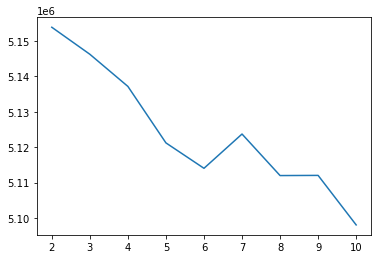

In [13]:
print(f'Testing K-Means parameters for item-user matrix:')

kmeans_range = range(2, 11)
kmeans_scores = Parallel(n_jobs = -1)(
    delayed(process_kmeans)(k, item_user_matrix) for k in kmeans_range
)

print('\nInertia Scores:', kmeans_scores)
kmeans_params, kmeans_data = tuple(zip(*kmeans_scores))
plt.plot(list(kmeans_params), list(kmeans_data))
plt.show()

Testing K-Means parameters for item similarity matrix:

Inertia Scores: [(2, 16450.35971007499), (3, 16135.688026945076), (4, 15917.379558764866), (5, 15730.089818541685), (6, 15563.088601109637), (7, 15484.400614840823), (8, 15418.972692689482), (9, 15365.645100559228), (10, 15336.769522582978)]


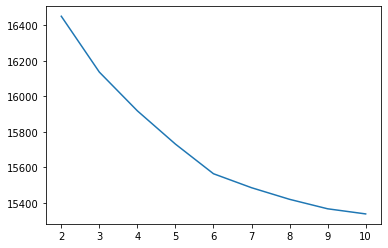

In [14]:
print(f'Testing K-Means parameters for item similarity matrix:')

kmeans_range = range(2, 11)
kmeans_scores = Parallel(n_jobs = -1)(
    delayed(process_kmeans)(k, item_similarity_df) for k in kmeans_range
)

print('\nInertia Scores:', kmeans_scores)
kmeans_params, kmeans_data = tuple(zip(*kmeans_scores))
plt.plot(list(kmeans_params), list(kmeans_data))
plt.show()

# t-SNE Visualization

/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


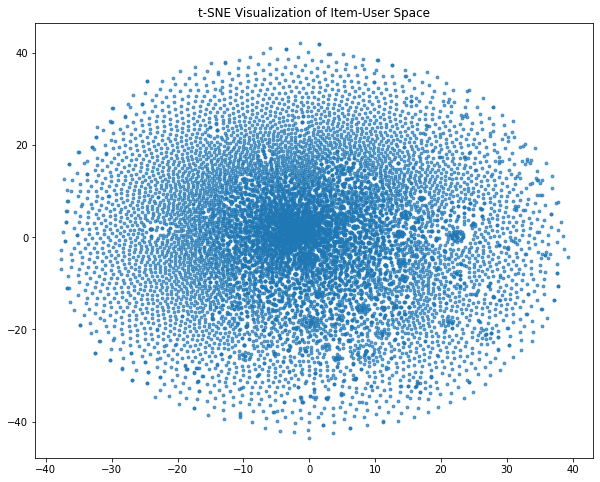

In [15]:
tsne = TSNE(n_components=2, random_state=42, learning_rate='auto', init='pca')
projected_data = tsne.fit_transform(item_user_matrix)

plt.figure(figsize=(10, 8))
plt.scatter(projected_data[:, 0], projected_data[:, 1], s=8, alpha=0.7)
plt.title('t-SNE Visualization of Item-User Space')
plt.show()

/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


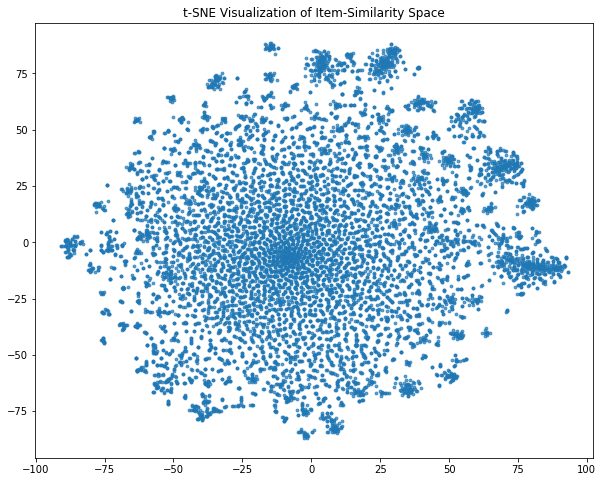

In [16]:
tsne = TSNE(n_components=2, random_state=42, learning_rate='auto', init='pca')
projected_data = tsne.fit_transform(item_similarity_df)

plt.figure(figsize=(10, 8))
plt.scatter(projected_data[:, 0], projected_data[:, 1], s=8, alpha=0.7)
plt.title('t-SNE Visualization of Item-Similarity Space')
plt.show()